# Figure 3: polymerization wave in REF52 cells

This jupyter notebook is used to calculate delays of the myosin and rGBD channels with respect to actin.


# Load required packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

from napari.utils.colormaps import label_colormap
from napari_timestamper import render_as_rgb

import napari

from arcos4py.tools import track_events_image, remove_image_background
from arcos4py.tools._detect_events import upscale_image
from arcos4py.tools._cleandata import blockwise_median

from skimage import io
from skimage.filters import gaussian
from skimage.filters import rank
from skimage.measure import regionprops_table

from scipy import ndimage
from scipy import stats
from scipy.signal import correlate, correlation_lags
from statsmodels.tsa.tsatools import detrend

from basicpy import BaSiC
from numba import njit, prange

In [12]:
DIR_CORE = "../../data/4_polymerization_wave"
DIR_IN = f"{DIR_CORE}/input-data"
DIR_OUT_DATA = f"{DIR_CORE}/output-data"
DIR_OUT_PLOT = f"{DIR_CORE}/output-plots"
DIR_OUT_VIDEO = f"{DIR_CORE}/output-videos"

SAMPLE_PERIOD_S = 10 # sample period in seconds
WINDOW_SIZE = 100  # window size in frames; set as needed

colors = ["#046735", "#76CDE8", "#7A2989"]
names = ["actin", "myosin", "rGBD"]

# create a deterministic CyclicColormap for the tracked waves
cmap = label_colormap(num_colors=256, seed=0.999) 

In [3]:
# Create directories for outputting plots and data

if not os.path.exists(DIR_OUT_DATA):
    os.makedirs(DIR_OUT_DATA)
    print(f"Directory {DIR_OUT_DATA} created successfully!")
else:
    print(f"Directory {DIR_OUT_DATA} already exists!")

if not os.path.exists(DIR_OUT_PLOT):
    os.makedirs(DIR_OUT_PLOT)
    print(f"Directory {DIR_OUT_PLOT} created successfully!")
else:
    print(f"Directory {DIR_OUT_PLOT} already exists!")

if not os.path.exists(DIR_OUT_VIDEO):
    os.makedirs(DIR_OUT_PLOT)
    print(f"Directory {DIR_OUT_VIDEO} created successfully!")
else:
    print(f"Directory {DIR_OUT_VIDEO} already exists!")

Directory ../../data/4_polymerization_wave/output-data already exists!
Directory ../../data/4_polymerization_wave/output-plots already exists!
Directory ../../data/4_polymerization_wave/output-videos already exists!


# Define functions

In [4]:
def compute_confidence_interval(data, confidence_level=0.95):
    """
    Compute the confidence interval for the given data.

    Parameters:
    - data (array-like): The data for which to compute the confidence interval.
    - confidence_level (float): The confidence level for the interval (default is 0.95).

    Returns:
    - tuple: The mean and the confidence interval as (mean, (lower_bound, upper_bound)).
    """
    mean = np.mean(data)
    sem = stats.sem(data)
    degrees_of_freedom = len(data) - 1
    t_score = stats.t.ppf((1 + confidence_level) / 2., degrees_of_freedom)
    margin_of_error = t_score * sem
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    return mean, confidence_interval

def match_histogram(source, template):
    hist_source, bin_edges = np.histogram(source.ravel(), bins=65536, range=(0, 65536))
    hist_template, _ = np.histogram(template.ravel(), bins=65536, range=(0, 65536))

    cdf_source = hist_source.cumsum() / hist_source.sum()
    cdf_template = hist_template.cumsum() / hist_template.sum()

    lookup_table = np.zeros(65536, dtype=np.uint16)
    j = 0
    for i in range(65536):
        while cdf_template[j] < cdf_source[i] and j < 65535:
            j += 1
        lookup_table[i] = j

    matched = lookup_table[source]
    return matched


def match_histogram_stack(img_stack, template):
    matched_stack = np.zeros_like(img_stack)
    for i in range(img_stack.shape[0]):
        matched_stack[i] = match_histogram(img_stack[i], template)
    return matched_stack


def filter_by_duration(labeled_stack, min_duration):
    """
    Removes tracks from a labeled image stack if their duration is less than the specified minimum.
    """
    labeled_stack = np.copy(labeled_stack)

    unique_labels = np.unique(labeled_stack)[1:]  # Exclude background (label 0)

    for label in unique_labels:
        # Get the coordinates of all pixels belonging to the current label (track) for each time point
        time_points = np.unique(np.where(labeled_stack == label)[0])

        # If the duration is less than min_duration, remove the track
        if len(time_points) < min_duration:
            labeled_stack[labeled_stack == label] = 0

    return labeled_stack


def correct_flatfield(raw_image: np.ndarray, flatfield_image: np.ndarray, darkfield_image: np.ndarray) -> np.ndarray:
    """
    Corrects flatfield in a microscopy image using dark field correction and gain.

    see wiki: https://en.wikipedia.org/wiki/Flat-field_correction

    Arguments
    ---------
        raw_image (np.ndarray): numpy array, the raw image to correct
        flatfield_image (np.ndarray): numpy array, the flatfield image
        darkfield_image (np.ndarray): numpy array, the darkfield image

    Returns
    -------
        np.ndarray: Corrected image.
    """
    # Ensure the images are in float format to avoid division issues
    raw_image = raw_image.astype(np.float32)
    flatfield_image = flatfield_image.astype(np.float32)
    darkfield_image = darkfield_image.astype(np.float32)

    # Calculate the image-averaged value of (F - D)
    m = np.mean(flatfield_image - darkfield_image)

    # Calculate the gain
    gain = m / (flatfield_image - darkfield_image)

    # Apply the correction formula: C = (R - D) * G
    corrected_image = (raw_image - darkfield_image) * gain

    return corrected_image


def correct_flatfield_stack(stack, flatfield, darkfield):
    corrected_stack = np.zeros_like(stack)
    for i in range(stack.shape[0]):
        corrected_stack[i] = correct_flatfield(stack[i], flatfield, darkfield)
    return corrected_stack


def post_process_results(results_list, intensity_column: str = "normalized_intensity"):
    """
    Convert results to a Pandas DataFrame and normalize intensities by event_id.
    """
    # Convert to DataFrame

    df = pd.DataFrame(results_list, columns=["event_id", "frame", "intensity", "channel", "middle_frame"])
    df["filtered_intensity"] = df.groupby(["event_id", "channel", "middle_frame"])["intensity"].transform(
        lambda x: ndimage.median_filter(x, size=3, mode="nearest")
    )


    # normalize intensitiesdf
    df["normalized_intensity"] = df.groupby(["event_id", "channel", "middle_frame"])["filtered_intensity"].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    # detrend intensities
    df["detrended_intensities"] = df.groupby(["event_id", "channel", "middle_frame"])["normalized_intensity"].transform(
        lambda x: detrend(x, order=1)
    )

    # add a column per channel
    df = df.pivot_table(
        index=["event_id", "frame", "middle_frame"], columns="channel", values=intensity_column
    ).reset_index()
    return df


@njit(parallel=False)
def get_event_properties(event_image, event_id):
    """
    Identify the start and end frames of an event and its duration.
    """
    filtered_event = np.where(event_image == event_id, 1, 0).astype(np.uint8)
    num_frames = filtered_event.shape[0]

    # Pre-allocate an array to store frames with data
    frames_with_data = np.zeros(num_frames, dtype=np.int32)
    count = 0  # To keep track of how many frames contain data

    for i in prange(num_frames):
        if np.any(filtered_event[i]):
            frames_with_data[i] = 1
            if count == 0:
                start_frame = i
            end_frame = i
            count += 1

    if count == 0:
        return -1, -1, 0, None  # No data for this event

    # Compute the duration of the event
    duration = end_frame - start_frame + 1

    return start_frame, end_frame, duration, filtered_event


@njit
def apply_mask(data, mask):
    """
    Manually apply a 2D boolean mask to a 2D array.

    :param data: 2D array from which elements are selected.
    :param mask: 2D boolean array indicating which elements to select.
    :return: 1D array of selected elements.
    """
    # Pre-allocate a list with maximum possible size
    result = np.empty(data.size, dtype=data.dtype)

    # Counter for the number of elements added to the result
    count = 0
    for i in prange(data.shape[0]):
        for j in prange(data.shape[1]):
            if mask[i, j]:
                result[count] = data[i, j]
                count += 1

    # Resize the result to the actual number of selected elements
    return result[:count]


@njit
def compute_label_intensities(filtered_event, intensity_image, start_frame, end_frame, num_channels, window_size=100, padding_mode="edge", valid_windows_only=False):
    numer_of_middle_frames = range(start_frame, end_frame)
    valid_middle_frames = []
    
    # First pass: determine which middle frames are valid
    for middle_frame in numer_of_middle_frames:
        min_frame_range = middle_frame - window_size
        max_frame_range = middle_frame + window_size
        
        if valid_windows_only:
            if min_frame_range >= 0 and max_frame_range < filtered_event.shape[0]:
                valid_middle_frames.append(middle_frame)
        else:
            valid_middle_frames.append(middle_frame)
    
    # Allocate the intensities array for valid middle frames only
    intensities = np.zeros((window_size * 2, len(valid_middle_frames), num_channels))
    
    # Second pass: compute intensities only for valid middle frames
    for middle_frame_idx, middle_frame in enumerate(valid_middle_frames):
        min_frame_range = middle_frame - window_size
        max_frame_range = middle_frame + window_size
        
        label_image = filtered_event[middle_frame]

        for frame_idx in range(min_frame_range, max_frame_range):
            if frame_idx < 0:
                if padding_mode == "nan":
                    channel_data = np.full((intensity_image.shape[1], intensity_image.shape[2], num_channels), np.nan)
                elif padding_mode == "edge":
                    channel_data = intensity_image[0, :, :, :]
            elif frame_idx >= intensity_image.shape[0]:
                if padding_mode == "nan":
                    channel_data = np.full((intensity_image.shape[1], intensity_image.shape[2], num_channels), np.nan)
                elif padding_mode == "edge":
                    channel_data = intensity_image[-1, :, :, :]
            else:
                channel_data = intensity_image[frame_idx, :, :, :]

            for ch in range(num_channels):
                masked_data = apply_mask(channel_data[:, :, ch], label_image)
                if masked_data.size > 0:
                    intensities[frame_idx - min_frame_range, middle_frame_idx, ch] = (
                        np.nanmean(masked_data) if padding_mode == "nan" else masked_data.mean()
                    )

    return intensities, valid_middle_frames



@njit(parallel=True)
def analyze_events(event_image, intensity_image, event_ids, window_size, padding_mode="edge", valid_windows_only=False, min_duration=10):
    """ Analyze events in an event image and compute intensities for each event.

    Parameters:
    - event_image (np.ndarray): A 3D image stack where each frame contains the labeled events.
    - intensity_image (np.ndarray): A 4D image stack containing the intensity values for each channel.
    - event_ids (list): A list of event IDs to analyze.
    - window_size (int): The size of the window around the middle frame to compute the intensity.
    - padding_mode (str): The padding mode to use when the window goes out of bounds (default is "edge").
    - valid_windows_only (bool): If True, only valid windows are considered (default is False), otherwise, the window can go out of bounds and be padded.
    - min_duration (int): The minimum duration of an event to analyze (default is 10).

    Returns:
    - list: A list of tuples containing the event_id, frame, intensity, channel, and middle_frame.
    """
    num_events = len(event_ids)
    num_channels = intensity_image.shape[-1]
    results_list = []

    for i in prange(num_events):
        event_id = event_ids[i]
        print("Analyzing event", event_id)
        start_frame, end_frame, duration, filtered_event = get_event_properties(event_image, event_id)
        # print(f"Event {event_id} has duration {duration} frames")

        if duration < min_duration:
            print(event_id, "is too short to analyze")
            continue  # Skip short events

        intensities, valid_middle_frames = compute_label_intensities(
            filtered_event, intensity_image, start_frame, end_frame, num_channels, window_size, padding_mode, valid_windows_only
        )

        print("Event", event_id, "analyzed")
        # Store event_id, start_frame, end_frame, and intensities
        for middle_frame_idx, middle_frame in enumerate(valid_middle_frames):
            for frame_idx in range(intensities.shape[0]):
                for ch in range(num_channels):
                    results_list.append(
                        (
                            event_id,
                            start_frame + frame_idx,
                            intensities[frame_idx, middle_frame_idx, ch],
                            f"intensity_mean-{ch}",
                            middle_frame,
                        )
                    )

    return results_list


# Load the raw data

In [5]:
raw_data_lifeact_myosin_rgbd = io.imread("../../data/4_polymerization_wave/input-data/lifeact_myosin_rgbd7_w15TIRF-GFP_s1_t1.TIF_-_Stage2__Position_12_.tiff")

# Extract the individual channels and perform histogram matching to account for photobleaching

In [6]:
from tqdm.auto import tqdm

myosin_bl = []
rGBD_bl = []
actin_bl = []

# extract the individual channels
myosin = raw_data_lifeact_myosin_rgbd[..., 1]
rGBD = raw_data_lifeact_myosin_rgbd[..., 2]
actin = raw_data_lifeact_myosin_rgbd[..., 0]

# use first frame as reference for histogram matching
reference_myosin = myosin[0]
reference_rGBD = rGBD[0]
reference_actin = actin[0]

# perform histogram matching
myosin_bl.append(np.stack([match_histogram(img, reference_myosin) for img in tqdm(myosin)]))
rGBD_bl.append(np.stack([match_histogram(img, reference_rGBD) for img in tqdm(rGBD)]))
actin_bl.append(np.stack([match_histogram(img, reference_actin) for img in tqdm(actin)]))
myosin_bl = np.concatenate(myosin_bl)
rGBD_bl = np.concatenate(rGBD_bl)
actin_bl = np.concatenate(actin_bl)

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

# Perform Flatfield Correction

In [7]:
basic_myosin = BaSiC(get_darkfield=True, smoothness_flatfield=1, smoothness_darkfield=2)
basic_myosin.fit(myosin_bl)

basic_rGBD = BaSiC(get_darkfield=True, smoothness_flatfield=1, smoothness_darkfield=2)
basic_rGBD.fit(rGBD_bl)

basic_actin = BaSiC(get_darkfield=True, smoothness_flatfield=0.5, smoothness_darkfield=1)
basic_actin.fit(actin_bl)

## Show estimated flatfield image

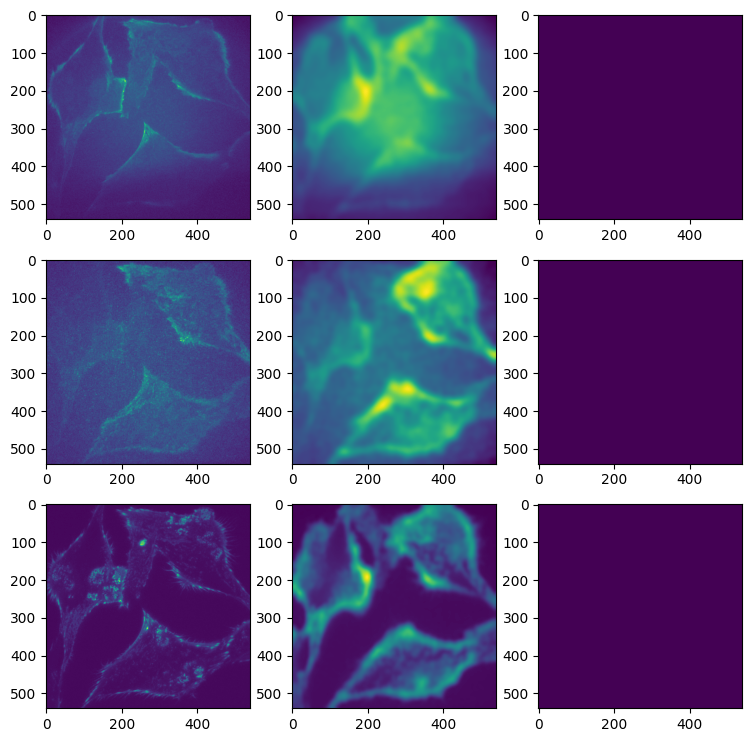

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax, img, b in zip(axes, [myosin_bl, rGBD_bl, actin_bl], [basic_myosin, basic_rGBD, basic_actin]):
    ax[0].imshow(img[0])
    ax[1].imshow(b.flatfield)
    ax[2].imshow(b.darkfield)

## Apply correction and show corrected image

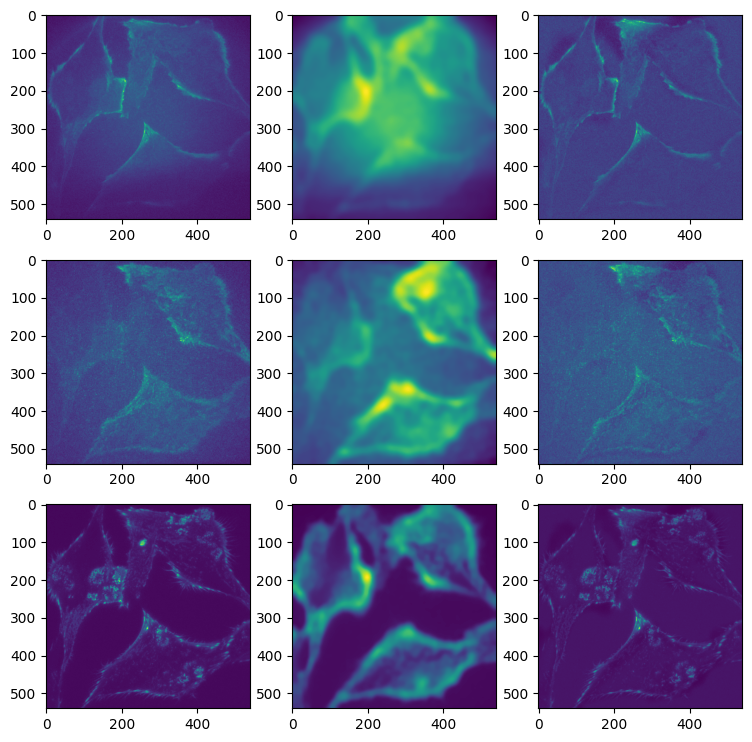

In [22]:
ff_filtered_myosin = ndimage.median_filter(basic_myosin.flatfield, 10)
ff_filtered_rGBD = ndimage.median_filter(basic_rGBD.flatfield, 10)
ff_filtered_actin = ndimage.median_filter(basic_actin.flatfield, 10)

myosin_corrected = correct_flatfield(myosin_bl[0], ff_filtered_myosin, basic_myosin.darkfield)
rGBD_corrected = correct_flatfield(rGBD_bl[0], ff_filtered_rGBD, basic_rGBD.darkfield)
actin_corrected = correct_flatfield(actin_bl[0], ff_filtered_actin, basic_actin.darkfield)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax, ori, ff, ori_corr in zip(
    axes,
    [myosin[0], rGBD[0], actin[0]],
    [ff_filtered_myosin, ff_filtered_rGBD, ff_filtered_actin],
    [myosin_corrected, rGBD_corrected, actin_corrected],
):
    ax[0].imshow(ori)
    ax[1].imshow(ff)
    ax[2].imshow(ori_corr)

In [23]:
# apply flatfield correction to the entire stack
myosin_corrected = correct_flatfield_stack(myosin_bl, ff_filtered_myosin, basic_myosin.darkfield)
rGBD_corrected = correct_flatfield_stack(rGBD_bl, ff_filtered_rGBD, basic_rGBD.darkfield)
actin_corrected = correct_flatfield_stack(actin_bl, ff_filtered_actin, basic_actin.darkfield)

In [24]:
binned_actin = blockwise_median(actin_corrected, (1, 2, 2))

# Remove the background from the actin channel 

In [25]:
actin_bg = remove_image_background(binned_actin, size=(100, 1, 1), filter_type="median", crop_time_axis=True)
actin_bg = np.where(actin_bg < 0, 0, actin_bg)

# Perform Gaussian filtering on the background-subtracted actin channel to remove noise

In [26]:
filtered_actin_bg = gaussian(actin_bg, sigma=1)

# Track events

In [27]:
if napari.current_viewer() is None:
    viewer = napari.Viewer()

viewer.add_image(myosin_corrected[0], name="myosin")

<Image layer 'myosin' at 0x50aefc730>

In [28]:
tracked_waves = track_events_image(
    filtered_actin_bg > 50,
    min_clustersize=20,
    eps=0,
    eps_prev=1,
    predictor=True,
    n_prev=3,
    downsample=1,
    clustering_method="hdbscan",
)

100%|██████████| 621/621 [00:10<00:00, 57.14it/s]


In [29]:
if napari.current_viewer() is None:
    viewer = napari.Viewer()

viewer.add_image(binned_actin[50:-50], name = "binned_actin")
viewer.add_labels(tracked_waves)

<Labels layer 'tracked_waves' at 0x48c0e33d0>

In [30]:
tracked_waves_filtered = rank.majority(tracked_waves, footprint=np.ones((5, 5, 5)))

In [31]:
events_upscaled = []
for t in tracked_waves_filtered:
    t_img = upscale_image(t, 2)
    events_upscaled.append(t_img)

events_upscaled = np.stack(events_upscaled)

In [32]:
if napari.current_viewer() is None:
    viewer = napari.Viewer()

viewer.add_image(actin_corrected[50:-50], name="actin", colormap="gray_r")
viewer.add_labels(events_upscaled, name="events_upscaled")

<Labels layer 'events_upscaled' at 0x500cf4370>

## Save intermediate Data

In [20]:
# SAVE THE DATA
io.imsave(f"{DIR_CORE}/{DIR_OUT_DATA}/actin_corrected.tif", actin_corrected)
io.imsave(f"{DIR_CORE}/{DIR_OUT_DATA}/myosin_corrected.tif", myosin_corrected)
io.imsave(f"{DIR_CORE}/{DIR_OUT_DATA}/rGBD_corrected.tif", rGBD_corrected)
io.imsave(f"{DIR_CORE}/{DIR_OUT_DATA}/tracked_waves.tif", events_upscaled)

/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_34092/1806926013.py:2: UserWarning: ../../data/4_polymerization_wave/output-data/actin_corrected.tif is a low contrast image
  io.imsave("../../data/4_polymerization_wave/output-data/actin_corrected.tif", actin_corrected)
/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_34092/1806926013.py:3: UserWarning: ../../data/4_polymerization_wave/output-data/myosin_corrected.tif is a low contrast image
  io.imsave("../../data/4_polymerization_wave/output-data/myosin_corrected.tif", myosin_corrected)
/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_34092/1806926013.py:4: UserWarning: ../../data/4_polymerization_wave/output-data/rGBD_corrected.tif is a low contrast image
  io.imsave("../../data/4_polymerization_wave/output-data/rGBD_corrected.tif", rGBD_corrected)
/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_34092/1806926013.py:5: UserWarning: ../../data/4_polymerization_wave/output-data/tracked_waves.tif

# Extract windowed intensity values for all channels

In [5]:
# load the data
actin_corrected = io.imread(f"{DIR_CORE}/{DIR_OUT_DATA}/actin_corrected.tif")
myosin_corrected = io.imread(f"{DIR_CORE}/{DIR_OUT_DATA}/myosin_corrected.tif")
rGBD_corrected = io.imread(f"{DIR_CORE}/{DIR_OUT_DATA}/rGBD_corrected.tif")
events_upscaled = io.imread(f"{DIR_CORE}/{DIR_OUT_DATA}/tracked_waves.tif")

In [6]:
if napari.current_viewer() is None:
    viewer = napari.Viewer()

viewer.add_image(actin_corrected[50:-50], name="actin", scale = (1, 0.366, 0.366))
viewer.add_image(myosin_corrected[50:-50], name="myosin", scale = (1, 0.366, 0.366))
viewer.add_image(rGBD_corrected[50:-50], name="rGBD", scale = (1, 0.366, 0.366))
viewer.add_labels(events_upscaled, name="events_upscaled", scale = (1, 0.366, 0.366))

<Labels layer 'events_upscaled' at 0x405610fd0>

In [34]:
event_ids = np.unique(events_upscaled)[1:]  # Assuming 0 is background

# Run the analysis
results_list = analyze_events(
    events_upscaled.astype(float),
    np.stack([actin_corrected, myosin_corrected, rGBD_corrected], axis=-1, dtype=float)[50:-50],
    event_ids,
    WINDOW_SIZE,
    valid_windows_only=True,
    min_duration=20,
)

Analyzing eventAnalyzing event 64
Analyzing event 80
Analyzing event 38
Analyzing event 159
Analyzing event 142
Analyzing event 12
Analyzing event 128
Analyzing event 1
Analyzing event 97
Analyzing event 25
Analyzing event 112
 52
64 is too short to analyze
Analyzing event 65
1 is too short to analyze
Analyzing event 2
Event 159 analyzed
Analyzing event 160
Event 12 analyzed
Analyzing event 13
128 is too short to analyze
Analyzing event 129
97 is too short to analyze
Analyzing event 98
52 is too short to analyze
Analyzing event 53
Event 25 analyzed
Analyzing event 26
65 is too short to analyze
Analyzing event 66
53 is too short to analyze
Analyzing event 54
13 is too short to analyze
Analyzing event 14
Event 160 analyzed
Analyzing event 161
66 is too short to analyze
Analyzing event 67
54 is too short to analyze
Analyzing event 56
Event 14 analyzed
Analyzing event 15
Event 161 analyzed
Analyzing event 162
Event 26 analyzed
Analyzing event 27
Event 15 analyzed
Analyzing event 16
Event 1

In [35]:
# Post-process the results, smooths, normalizes and detrends the intensities
df = post_process_results(results_list, "detrended_intensities")
# subtract first frame from all frames in the frame column
df["frame_count"] = df.groupby(["event_id"])["frame"].transform(lambda x: x - x.min())
print("Number of events analyzed:", len(df["event_id"].unique()))
df.head()

Number of events analyzed: 51


channel,event_id,frame,middle_frame,intensity_mean-0,intensity_mean-1,intensity_mean-2,frame_count
0,2,0,100,-0.293485,0.343266,0.198838,0
1,2,0,101,-0.227986,0.356845,0.336749,0
2,2,0,102,-0.259732,0.418175,0.119363,0
3,2,0,103,-0.289695,0.435747,0.257206,0
4,2,0,104,-0.334201,0.333250,0.179923,0


## Plot Results

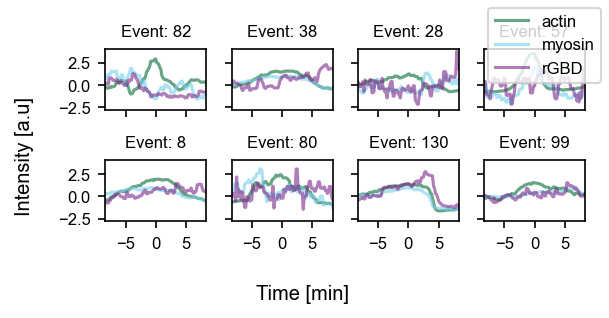

In [36]:
# rc config to save svgs as text
plt.rcParams["svg.fonttype"] = "none"
# set font to Arial
plt.rcParams["font.sans-serif"] = "Arial"
# set font size to 8
plt.rcParams.update({"font.size": 8})

# Sample a random set of rows from the DataFrame
unique_combinations = df["event_id"].drop_duplicates().sample(n=8, random_state=0)

# Create a 4x4 grid of plots
fig, axes = plt.subplots(2, 4, figsize=(4, 2), sharex=True, sharey=True, dpi=150)
axes = axes.flatten()

# Iterate over each unique combination and plot
for i, (ax, row) in enumerate(zip(axes, unique_combinations)):
    # Filter the original DataFrame for the current combination
    grp = df[(df["event_id"] == row)]
    grp = grp[grp["middle_frame"] == grp["middle_frame"].sample(1, random_state=1337).iloc[0]]

    # # Plot the data
    ax.plot((grp["frame_count"] - WINDOW_SIZE) * SAMPLE_PERIOD_S / 60, grp["intensity_mean-0"], color=colors[0], label=names[0], alpha=0.6)
    ax.plot((grp["frame_count"] - WINDOW_SIZE) * SAMPLE_PERIOD_S / 60, grp["intensity_mean-1"], color=colors[1], label=names[1], alpha=0.6)
    ax.plot((grp["frame_count"] - WINDOW_SIZE) * SAMPLE_PERIOD_S / 60, grp["intensity_mean-2"], color=colors[2], label=names[2], alpha=0.6)

    ax.set_title(f'Event: {row}', fontsize=8)
    ax.set_xlim(-WINDOW_SIZE*SAMPLE_PERIOD_S/2/60, WINDOW_SIZE*SAMPLE_PERIOD_S/2/60)

fig.supylabel("Intensity [a.u]")
fig.supxlabel("Time [min]")
fig.legend(labels=names)

plt.tight_layout()
plt.savefig(f"{DIR_CORE}/{DIR_OUT_PLOT}/sample_event.pdf")
plt.show()

0
5
5


/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_34092/3081143811.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ticks.astype(int))


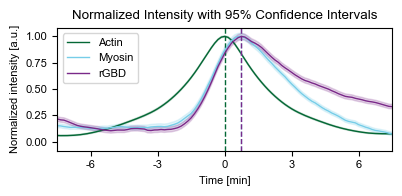

In [39]:
# Example dataframe `df` structure:
# Columns: frame_count, intensity_mean-0, intensity_mean-1, intensity_mean-2

# Calculate mean, std, and SEM for each frame count
channels = ["intensity_mean-0", "intensity_mean-1", "intensity_mean-2"]
df_summary = df.groupby("frame_count")[channels].agg(['mean', 'std', 'count']).reset_index()

# Flatten the multi-level columns
df_summary.columns = ['frame_count'] + [f"{col[0]}_{col[1]}" for col in df_summary.columns[1:]]

# Min-max scale the means and calculate 95% CI
for channel in channels:
    mean_col = f"{channel}_mean"
    std_col = f"{channel}_std"
    count_col = f"{channel}_count"
    
    # Scale the mean to have a min of 0 and max of 1
    min_val = df_summary[mean_col].min()
    max_val = df_summary[mean_col].max()
    df_summary[mean_col] = (df_summary[mean_col] - min_val) / (max_val - min_val)
    
    # Adjust std (error bars) based on the same scaling
    scale_factor = 1 / (max_val - min_val)
    df_summary[std_col] = df_summary[std_col] * scale_factor
    
    # Compute SEM and 95% CI
    df_summary[f"{channel}_sem"] = df_summary[std_col] / np.sqrt(df_summary[count_col])
    df_summary[f"{channel}_ci"] = df_summary[f"{channel}_sem"] * 1.96  # 95% CI

# Convert back to long format for plotting
long_df = pd.melt(df_summary, id_vars="frame_count",
                  value_vars=[f"{channel}_mean" for channel in channels],
                  var_name="Channel", value_name="Mean_intensity")

# Add confidence intervals
long_df["CI"] = pd.melt(df_summary, id_vars="frame_count",
                        value_vars=[f"{channel}_ci" for channel in channels],
                        value_name="CI")["CI"]

# Map channel names for better readability
channel_mapping = {
    "intensity_mean-0_mean": "Actin",
    "intensity_mean-1_mean": "Myosin",
    "intensity_mean-2_mean": "rGBD"
}
long_df["Channel"] = long_df["Channel"].map(channel_mapping)

# Plotting with confidence intervals

# frame_count -WINDOW_SIZE
long_df["frame_count"] = long_df["frame_count"] - WINDOW_SIZE

fig, ax = plt.subplots(figsize=(4, 2))
for idx, channel in enumerate(long_df["Channel"].unique()):
    subset = long_df[long_df["Channel"] == channel]
    sns.lineplot(
        data=subset,
        x="frame_count",
        y="Mean_intensity",
        label=channel,
        ax=ax,
        color=colors[idx],
        linewidth=1,
    )
    # Add confidence intervals
    ax.fill_between(subset["frame_count"], 
                    subset["Mean_intensity"] - subset["CI"], 
                    subset["Mean_intensity"] + subset["CI"], 
                    alpha=0.2, color=colors[idx])

    print(subset["Mean_intensity"].argmax() - WINDOW_SIZE)
    
    ax.axvline(x=subset["Mean_intensity"].argmax() - WINDOW_SIZE, linestyle="--", linewidth=1, color=colors[idx])

# Customize plot appearance
ax.set_title("Normalized Intensity with 95% Confidence Intervals")
ax.set_xlabel("Time [min]")
ax.set_ylabel("Normalized intensity [a.u.]")
# ax.legend(title="Channel")
# convert x-axis to minutes, one frame is 10s
ax.set_xlim(-50, 50)
ticks = ax.get_xticks()
ticks = ticks * SAMPLE_PERIOD_S / 60
ax.set_xticklabels(ticks.astype(int))
plt.tight_layout()
plt.savefig(f"{DIR_CORE}/{DIR_OUT_PLOT}/normalized_intensity.pdf")
plt.show()


# Data Export

## Snapshots of the entire FOVs

In [40]:
viewer = napari.Viewer()
viewer.add_image(actin_corrected[50:-50], name="lifeact", colormap="gray_r", contrast_limits=[125,800])
labels = viewer.add_labels(events_upscaled, name="tracked_waves", colormap=cmap)

In [46]:
samples = np.linspace(0, 90, 4, dtype=int)

rgb_events = []
rbg_lifeact = []
viewer.layers["lifeact"].visible = True
viewer.layers["tracked_waves"].visible = True
for img in samples:
    viewer.dims.set_current_step(0, img)
    rgb_events.append(render_as_rgb(viewer, upsample_factor=1))

viewer.layers["tracked_waves"].visible = False

for img in samples:
    viewer.dims.set_current_step(0, img)
    rbg_lifeact.append(render_as_rgb(viewer, upsample_factor=1))

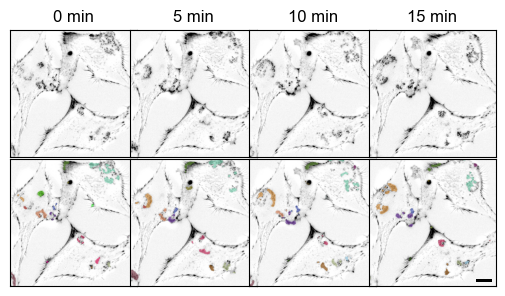

In [49]:
plt.rcParams["svg.fonttype"] = "none"
plt.rc('pdf', fonttype=42)
# set font to arial
plt.rcParams["font.sans-serif"] = "Arial"

fig, ax = plt.subplots(2, 4, figsize=(5.5, 3))

for idx, val in enumerate(samples):
    ax[0, idx].imshow(rbg_lifeact[idx])
    # in minutes
    ax[0, idx].set_title(f"{val*SAMPLE_PERIOD_S/60:.0f} min")
    # remove ticks
    ax[0, idx].set_xticks([])
    ax[0, idx].set_yticks([])

for idx, val in enumerate(samples):
    ax[1, idx].imshow(rgb_events[idx])
    # remove ticks
    ax[1, idx].set_xticks([])
    ax[1, idx].set_yticks([])
    if val == samples[-1]:
        scalebar = ScaleBar(
            0.366,
            "um",
            length_fraction=0.2,
            location="lower right",
            scale_loc="none",
            box_alpha=0,
            width_fraction=0.025,
        )
        ax[1, idx].add_artist(scalebar)

plt.tight_layout(h_pad=1, w_pad=-3)
plt.savefig(f"{DIR_CORE}/{DIR_OUT_PLOT}/pannels_insert.pdf", dpi = 600)
# scalebar = 25 um

## Snapshots of an event

In [52]:
viewer = napari.Viewer()
viewer.add_image(actin_corrected[50:-50], name="lifeact", colormap="gray_r")
viewer.add_labels(events_upscaled, name="tracked_waves", colormap=cmap)

<Labels layer 'tracked_waves' at 0x49a3b0d00>

In [53]:
# make crop of single event and follow it over time with high temporal resolution

# get the event id
event_id = 15

# get the frames of the event
event_frames = np.where(events_upscaled == event_id)

# get the first frame of the event
first_frame = event_frames[0][0]

# get bounding box of the event
bbox = ndimage.find_objects(events_upscaled == event_id)[0]

# crop the event
cropped_event_actin = actin_corrected[50:-50][bbox]
cropped_event = events_upscaled[bbox]
# plot 10 frames as a sequence of the event cropped to the bounding box

# add to napari viewer
viewer = napari.Viewer()
viewer.add_image(cropped_event_actin, name="actin", colormap="gray_r")
viewer.add_labels(cropped_event, name="tracked_waves", colormap=cmap)



<Labels layer 'tracked_waves' at 0x495307e50>

In [55]:
# create rgb images of the event
rgb_event = render_as_rgb(viewer, axis=0, upsample_factor=4)
viewer.layers["tracked_waves"].visible = False
rgb_actin_only = render_as_rgb(viewer, axis=0, upsample_factor=4)

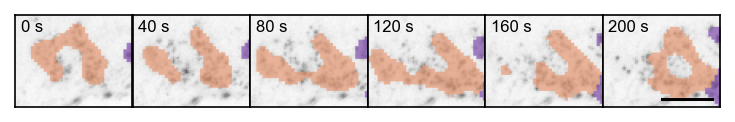

In [56]:
plt.rcParams["svg.fonttype"] = "none"
plt.rc('pdf', fonttype=42)
# set font to arial
plt.rcParams["font.sans-serif"] = "Arial"

fig, ax = plt.subplots(1, 6, figsize=(5, 2), dpi=150)

for idx, val in enumerate(range(first_frame, first_frame + 22, 4)):
    ax[idx].imshow(rgb_event[val])
    # remove ticks
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    # Add text to the upper left corner
    ax[idx].text(0.05, 0.95, f'{val*SAMPLE_PERIOD_S:.0f} s', transform=ax[idx].transAxes,
                    fontsize=8, verticalalignment='top', horizontalalignment='left')
    ax[idx].margins(0, 0)
    if idx == 5:
        scalebar = ScaleBar(0.15/4, "um", length_fraction=0.5, location='lower right',  scale_loc="none", box_alpha=0, width_fraction=0.025) # 4x upsampled # size is 5 um
        ax[idx].add_artist(scalebar)

plt.tight_layout(h_pad=0, w_pad=0)

plt.savefig(f"{DIR_CORE}/{DIR_OUT_PLOT}/event_sequence.pdf", dpi = 600)
plt.show()


## Export stacks

In [47]:
viewer = napari.Viewer()
viewer.add_image(actin_corrected[50:-50], name="actin", scale = (1, 0.366, 0.366), colormap="gray_r", contrast_limits=(100, 900), gamma=1)
viewer.add_image(myosin_corrected[50:-50], name="myosin", scale = (1, 0.366, 0.366), colormap="gray_r", contrast_limits=(250, 400), gamma=1.6)
viewer.add_image(rGBD_corrected[50:-50], name="rGBD", scale = (1, 0.366, 0.366), colormap="gray_r", contrast_limits=(180, 400), gamma=1.3)

<Image layer 'rGBD' at 0x50accf3d0>

In [ ]:
for layer in viewer.layers:
    layer.visible = False

viewer.layers["actin"].visible = True

actin_rgb =  render_as_rgb(viewer, axis=0, upsample_factor=2)

viewer.layers["actin"].visible = False

viewer.layers["myosin"].visible = True

myosin_rgb =  render_as_rgb(viewer, axis=0, upsample_factor=2)

viewer.layers["myosin"].visible = False

viewer.layers["rGBD"].visible = True

rGBD_rgb =  render_as_rgb(viewer, axis=0, upsample_factor=2)

viewer.layers["rGBD"].visible = False

In [ ]:
from napari_timestamper import save_image_stack
save_image_stack(actin_rgb, "actin_rgb.tif")
save_image_stack(myosin_rgb, "myosin_rgb.tif")
save_image_stack(rGBD_rgb, "rGBD_rgb.tif")

# Validation of Data aggregation and time delay estimation
Here, we shift one reference channel by n frames and compute the time-delay between the unshifted and shifted reference channel. Hence, we can validate the time delay estimation based on the used extraction method.

In [50]:
actin_corrected = io.imread(f"{DIR_CORE}/{DIR_OUT_DATA}/actin_corrected.tif")
events_upscaled = io.imread(f"{DIR_CORE}/{DIR_OUT_DATA}/tracked_waves.tif")

actin_shifted = actin_corrected[10:]
actin_unshifted = actin_corrected[:-10]

In [51]:
event_ids = np.unique(events_upscaled)[1:]  # Assuming 0 is background

results_list = analyze_events(
    events_upscaled.astype(float),
    np.stack([actin_unshifted, actin_shifted], axis=-1, dtype=float)[50:-50],
    event_ids.astype(float),
    WINDOW_SIZE,
    valid_windows_only=True,
    min_duration=20,
)

Analyzing eventAnalyzing event 1.0
Analyzing event 25.0
Analyzing event 76.0
Analyzing event 40.0
Analyzing event 12.0
Analyzing event 154.0
Analyzing event 65.0
Analyzing event 142.0
Analyzing event 110.0
Analyzing event 95.0
Analyzing event 127.0
 51.0
1.0 is too short to analyze
Analyzing event 2.0
Event 12.0 analyzed
Analyzing event 13.0
65.0 is too short to analyze
Analyzing event 66.0
154.0 is too short to analyze
Analyzing event 155.0
142.0 is too short to analyze
Analyzing event 143.0
51.0 is too short to analyze
Analyzing event 52.0
Event 2.0 analyzed
Analyzing event 3.0
Event 40.0 analyzed
Analyzing event 41.0
66.0 is too short to analyze
Analyzing event 67.0
Event 13.0 analyzed
Analyzing event 14.0
155.0 is too short to analyze
Analyzing event 157.0
143.0 is too short to analyze
Analyzing event 145.0
Event 127.0 analyzed
Analyzing event 130.0
52.0 is too short to analyze
Analyzing event 54.0
3.0 is too short to analyze
Analyzing event 4.0
41.0 is too short to analyze
Analyzi

In [52]:
df = post_process_results(results_list, "detrended_intensities")
df["frame_count"] = df.groupby(["event_id"])["frame"].transform(lambda x: x - x.min())
df.head()

channel,event_id,frame,middle_frame,intensity_mean-0,intensity_mean-1,frame_count
0,4.0,0,100,-0.896618,-1.061045,0
1,4.0,0,101,-0.902643,-1.079270,0
2,4.0,0,102,-0.880207,-1.118805,0
3,4.0,0,103,-0.972657,-1.087651,0
4,4.0,0,104,-1.007974,-0.893187,0


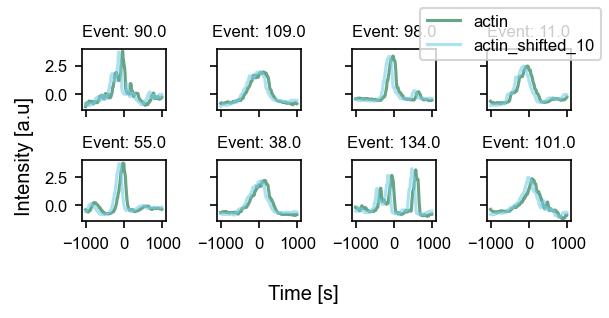

In [53]:
# rc config to save svgs as text
plt.rcParams["svg.fonttype"] = "none"
# set font to Arial
plt.rcParams["font.sans-serif"] = "Arial"
# set font size to 8
plt.rcParams.update({"font.size": 8})

names = ["actin", "actin_shifted_10"]

# Sample a random set of rows from the DataFrame
sampled_df = df["event_id"].drop_duplicates().sample(n=8, random_state=0)  # Assuming you want 16 plots on a 4x4 grid

# Extract unique combinations of 'event_id' and 'middle_frame'
unique_combinations = sampled_df

# Create a 4x4 grid of plots
fig, axes = plt.subplots(2, 4, figsize=(4, 2), sharex=True, sharey=True, dpi=150)
axes = axes.flatten()

# Iterate over each unique combination and plot
for i, (ax, row) in enumerate(zip(axes, unique_combinations)):
    # Filter the original DataFrame for the current combination
    grp = df[(df["event_id"] == row)]
    grp = grp[grp["middle_frame"] == grp["middle_frame"].sample(1, random_state=1337).iloc[0]]

    # # Plot the data
    ax.plot((grp["frame_count"]-WINDOW_SIZE)*10, grp["intensity_mean-0"], color=colors[0], label=names[0], alpha=0.6)
    ax.plot((grp["frame_count"]-WINDOW_SIZE)*10, grp["intensity_mean-1"], color=colors[1], label=names[1], alpha=0.6)

    ax.set_title(f'Event: {row}', fontsize=8)

fig.supylabel("Intensity [a.u]")
fig.supxlabel("Time [s]")
fig.legend(labels=names)

plt.tight_layout()
plt.show()

Max at:  0
Max at:  -10


/var/folders/3w/7bkm_96j7c15c_mwh6x1p5040000gn/T/ipykernel_34092/5323504.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ticks.astype(int))


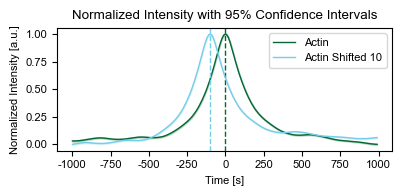

In [56]:
# Example dataframe `df` structure:
# Columns: frame_count, intensity_mean-0, intensity_mean-1, intensity_mean-2

# Calculate mean, std, and SEM for each frame count
channels = ["intensity_mean-0", "intensity_mean-1"]
df_summary = df.groupby("frame_count")[channels].agg(['mean', 'std', 'count']).reset_index()

# Flatten the multi-level columns
df_summary.columns = ['frame_count'] + [f"{col[0]}_{col[1]}" for col in df_summary.columns[1:]]

# Min-max scale the means and calculate 95% CI
for channel in channels:
    mean_col = f"{channel}_mean"
    std_col = f"{channel}_std"
    count_col = f"{channel}_count"
    
    # Scale the mean to have a min of 0 and max of 1
    min_val = df_summary[mean_col].min()
    max_val = df_summary[mean_col].max()
    df_summary[mean_col] = (df_summary[mean_col] - min_val) / (max_val - min_val)
    
    # Adjust std (error bars) based on the same scaling
    scale_factor = 1 / (max_val - min_val)
    df_summary[std_col] = df_summary[std_col] * scale_factor
    
    # Compute SEM and 95% CI
    df_summary[f"{channel}_sem"] = df_summary[std_col] / np.sqrt(df_summary[count_col])
    df_summary[f"{channel}_ci"] = df_summary[f"{channel}_sem"] * 1.96  # 95% CI

# Convert back to long format for plotting
long_df = pd.melt(df_summary, id_vars="frame_count",
                  value_vars=[f"{channel}_mean" for channel in channels],
                  var_name="Channel", value_name="Mean Intensity")

# Add confidence intervals
long_df["CI"] = pd.melt(df_summary, id_vars="frame_count",
                        value_vars=[f"{channel}_ci" for channel in channels],
                        value_name="CI")["CI"]

# Map channel names for better readability
channel_mapping = {
    "intensity_mean-0_mean": "Actin",
    "intensity_mean-1_mean": "Actin Shifted 10",
}
long_df["Channel"] = long_df["Channel"].map(channel_mapping)

# Plotting with confidence intervals

# frame_count -WINDOW_SIZE
long_df["frame_count"] = long_df["frame_count"] - WINDOW_SIZE

fig, ax = plt.subplots(figsize=(4, 2))
for idx, channel in enumerate(long_df["Channel"].unique()):
    subset = long_df[long_df["Channel"] == channel]
    sns.lineplot(
        data=subset,
        x="frame_count",
        y="Mean Intensity",
        label=channel,
        ax=ax,
        color=colors[idx],
        linewidth=1,
    )
    # Add confidence intervals
    ax.fill_between(subset["frame_count"], 
                    subset["Mean Intensity"] - subset["CI"], 
                    subset["Mean Intensity"] + subset["CI"], 
                    alpha=0.2, color=colors[idx])
    
    print("Max at: ", subset["Mean Intensity"].argmax() - WINDOW_SIZE)
    
    ax.axvline(x=subset["Mean Intensity"].argmax() - WINDOW_SIZE, linestyle="--", linewidth=1, color=colors[idx])

# Customize plot appearance
ax.set_title("Normalized Intensity with 95% Confidence Intervals")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Normalized Intensity [a.u.]")
# convert x-axis to minutes, one frame is 10s
# ax.set_xlim(-20, 20)    
ticks = ax.get_xticks()
ticks = ticks * 10
ax.set_xticklabels(ticks.astype(int))

plt.tight_layout()
plt.savefig(f"{DIR_CORE}/{DIR_OUT_PLOT}/normalized_intensity_actin_shift_10.pdf")
plt.show()
